Some initial imports, do **NOT** write any new code here:

In [1]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from huggingface_hub import hf_hub_download

In [2]:
from plotly.subplots import make_subplots
from plotly import graph_objs as go
from sklearn.metrics import precision_score, recall_score, accuracy_score
from torchvision.transforms import Normalize

from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import display, clear_output
from collections import Counter
from tqdm import tqdm

# Question 2: ECG Beat Classification and Anomaly Detection

Electrocardiography (ECG) records the electrical activity of the heart over time using electrodes placed on the skin. ECG signals are widely used in clinical practice for detecting arrhythmias, monitoring cardiac function, and guiding diagnosis and treatment. Automated analysis of ECG signals is therefore an important application area for deep learning, with direct implications for screening, triage, and decision support.

In this question, you will work with a cleaned ECG dataset. The dataset contains **197 records** drawn from **three arrhythmia databases**. All signals have been resampled to **128 Hz**, and each recording is approximately **30 minutes** in duration. Each record is stored as a Python dictionary with the following fields:

- `patient_id`: an anonymised identifier for the patient from whom the recording was obtained.  
- `source_db`: the originating database for this record.  
- `sampling_rate`: the sampling frequency of the signal in Hz (128 for this cleaned dataset).  
- `signal`: a one-dimensional array containing the ECG time series.  
- `beat_locs`: an array of sample indices marking the onset of each annotated heartbeat in the signal.  
- `beat_labels`: an array of integer labels associated with each beat location.

Beat labels in this assessment have been mapped to a simplified index space from **0** to **4**, where **0** denotes normal beats, **1** and **2** correspond to different abnormality subclasses (supra ventricular ectopic (SVEB) and ventricular ectopic beats (VEB)), and **3** represents unknown or other beats. The exact mapping between indices and the original clinical annotation classes is provided in the accompanying file `class_mapping.json`. You should refer to this file when interpreting the label distribution and when designing your models.

This question is divided into three parts:

- **Part 2.A – Exploratory Data Analysis and Tooling**: you will perform basic exploration of the ECG signals and annotations, and construct simple plotting and preprocessing utilities to support the later tasks.  
- **Part 2.B – Classification and Anomaly Detection**: you will build a supervised deep learning model for beat-level classification, using the simplified label scheme, and explicitly examine its behaviour for normal versus abnormal beats.  
- **Part 2.C – Discussion**: you will critically discuss your modelling choices, results, limitations, and potential improvements, in a concise written analysis guided by the prompts.

You should approach these parts progressively: insights and tools developed in Part 2.A are expected to inform and support your solutions in Parts 2.B and 2.C.

<br>

---

<br>

The next few blocks of code provided in the notebook will download the dataset, load the ECG records into memory, and import the accompanying class–mapping file required for interpreting the beat labels.

In [3]:
# Use this snippet to download the dataset
dataset = load_dataset("dpelacani/ecg-led2-cleaned")

# download class_mapping.json
mapping_path = hf_hub_download(
    repo_id="dpelacani/ecg-led2-cleaned",
    filename="class_mapping.json",
    repo_type="dataset"
)

# load it
with open(mapping_path, "r") as f:
    idx_to_class = json.load(f)

print(dataset, idx_to_class)  # print dataset and mapping

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/473 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/197 [00:00<?, ? examples/s]

class_mapping.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'source_db', 'sampling_rate', 'signal', 'beat_locs', 'beat_labels'],
        num_rows: 197
    })
}) {'0': 'NOR', '1': 'SVEB', '2': 'VEB', '3': 'UNK'}


<br><br>

## 2.A) Exploratory Data Analysis and Pre-processing

The goal of this part is to carry out a set of simple exploratory checks on the ECG dataset and to prepare the beat-level representation that will be used in later tasks. Two helper functions are provided:

- **`plot_signal`**: plots a segment of the ECG signal together with its annotated beat locations and labels.  
- **`split_by_beat`**: takes a full ECG recording and returns a list of individual beat segments based on the annotated beat locations.

Using these tools, you must complete the following:

1. **Visualise the data**  
   Use `plot_signal` to visualise a **subset of 50 consecutive beats** for **five different patients**, ensuring that beat locations and labels are annotated in the plot. These examples should give you an intuitive sense of how the signals vary across patients and beat types.

2. **Construct the beat-level dataset**  
   Use `split_by_beat` to compile a dataset where **each beat is one sample**. Build two aligned arrays/lists:
   - one containing the beat waveforms: `list[(floats)]`
   - one containing the corresponding beat labels (0–4) `list[(int)]`

3. **Apply a simple pre-processing filter**  
   Exclude beats whose durations fall outside physiologically plausible ranges. Specifically, keep only beats whose lengths fall between:  
   - **minimum length** corresponding to a **maximum heart rate of 240 bpm** (32 samples)  
   - **maximum length** corresponding to a **minimum heart rate of 30 bpm** (256 samples)  
   
   Beats outside this range should be removed, as they likely reflect annotation errors or segmentation issues.

4. **Plot summary statistics**  
   After filtering, produce two histograms:
   - one showing the **distribution of beat lengths**,  
   - one showing the **distribution of beat classes** (0–4).  

These steps should give you a clear initial understanding of the dataset and will provide the structured inputs required for the classification task in Part 2.B.

<br>

Here are the helper functions:

In [4]:
def plot_signal(
        signal,
        title="ECG Signal",
        sampling_rate=128,
        beat_locations=None,
        beat_annotations=None,
        ax = None,

    ):
    """
    Plots an ECG signal with optional anomalous beat annotations.
    Parameters:
        signal (np.ndarray): The ECG signal to plot.
        title (str): The title of the plot.
        sampling_rate (int): The sampling rate of the signal in Hz.
        beat_locations (list or np.ndarray): Indices of beat locations in the signal.
        beat_annotations (list): Annotations corresponding to the beat locations.
        ax (matplotlib.axes.Axes): Optional matplotlib axes to plot on.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(20, 5))

    time = np.arange(len(signal)) / sampling_rate / 60.
    ax.plot(time, signal)

    if beat_locations is not None:
        ax.scatter(beat_locations / sampling_rate / 60., signal[beat_locations], color='red', label='BEAT', marker='o')
        if beat_annotations is not None:
            for loc, ann in zip(beat_locations, beat_annotations):
                if ann != 'NOR':
                    ax.text(loc / sampling_rate / 60. + 0.05*np.max(time), signal[loc] + 0.05, ann, color='red', fontsize=8, weight='bold')

    ax.set_title(title)
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Normalised Amplitude")
    ax.set_ylim([-0.5, 1])
    ax.grid()

    if ax is None:
        plt.show()

In [5]:
def split_by_beat(signal, beat_locs):
    """
    Splits the ECG signal into individual beats based on beat locations.
    Parameters:
        signal (np.ndarray): The ECG signal to split.
        beat_locs (list or np.ndarray): Indices of beat locations in the signal.
    Returns:
        list: A list of individual beats extracted from the signal."""
    beats = []
    starts = [0] + beat_locs.tolist()[:-1]
    ends = beat_locs.tolist() + [len(signal)]
    for start, end in zip(starts, ends):
        beats.append(signal[start:end])
    return beats

<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

1. **Visualise the data**

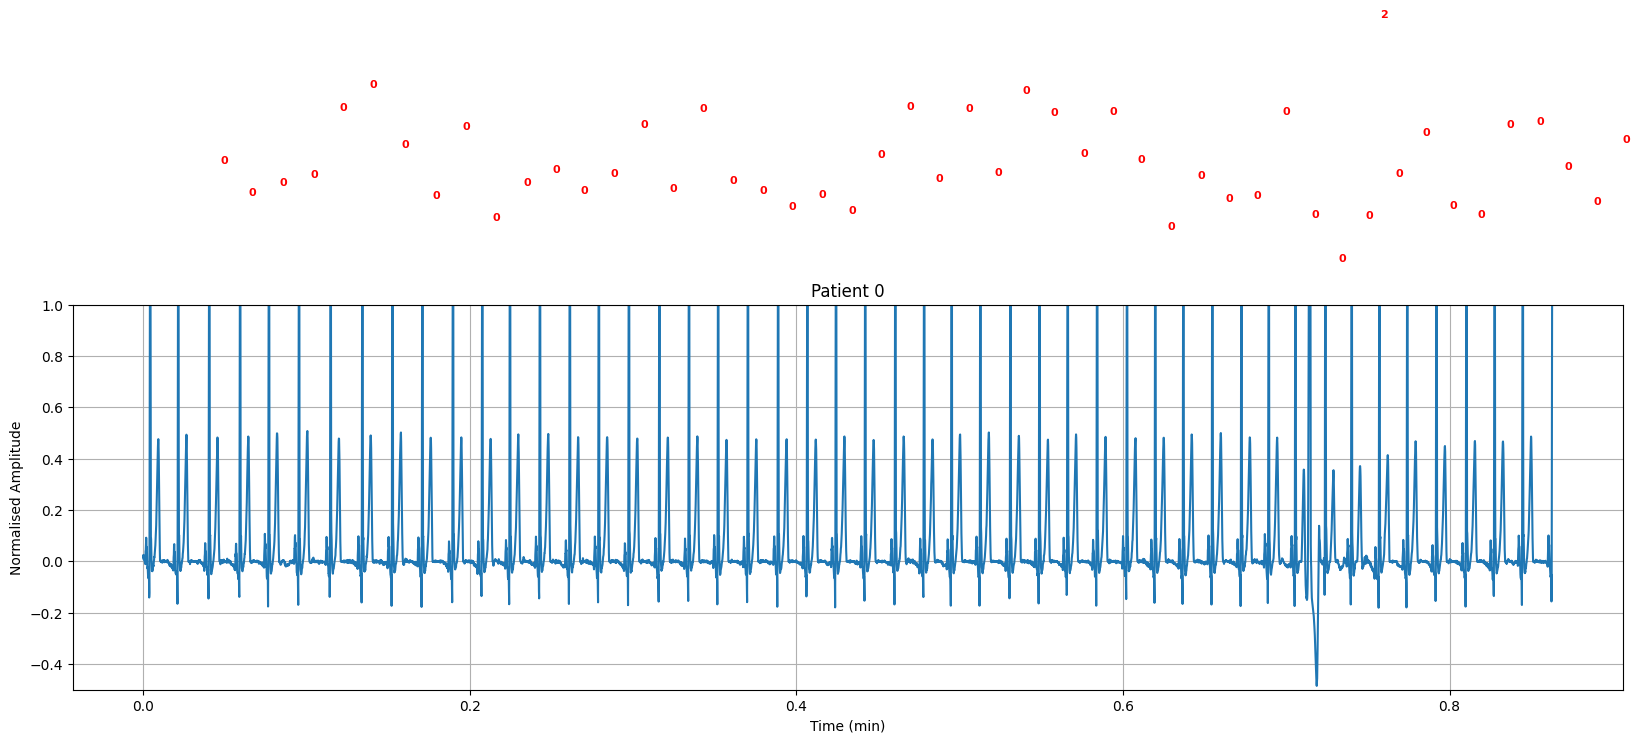

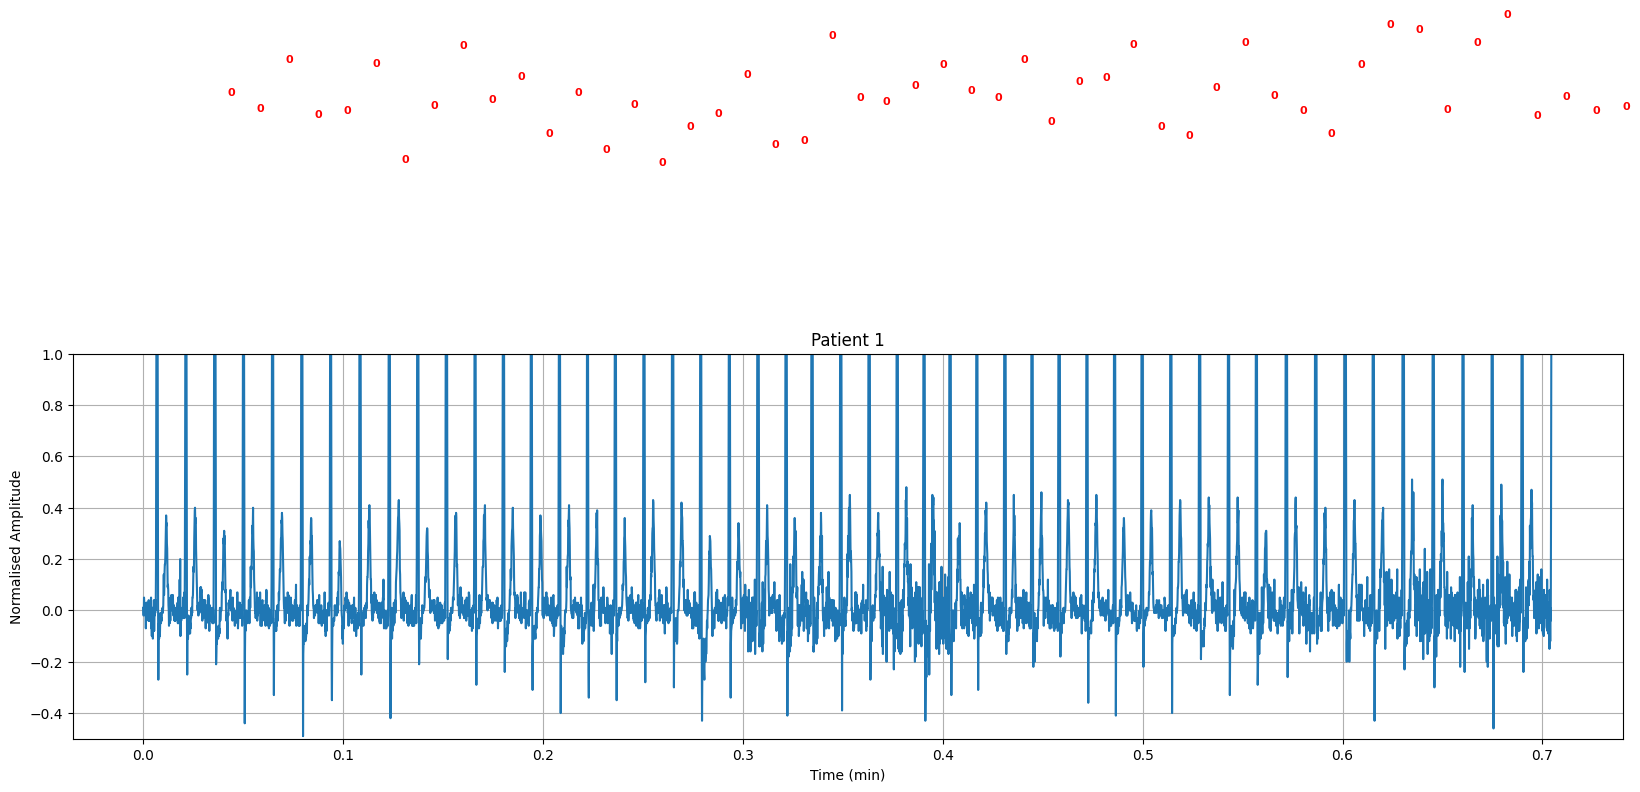

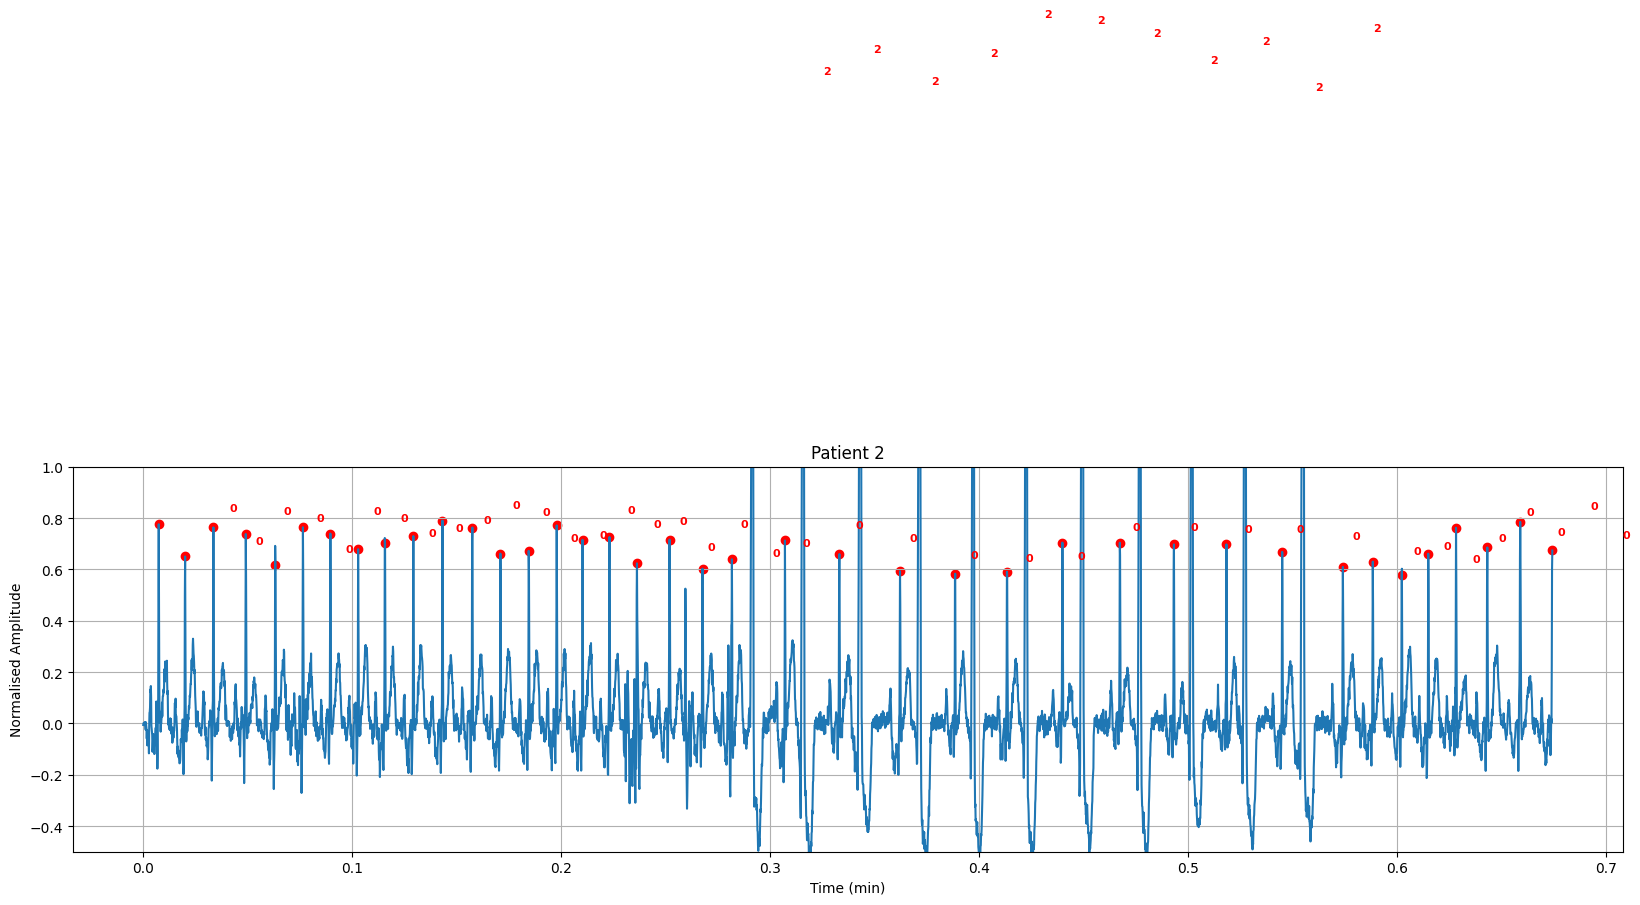

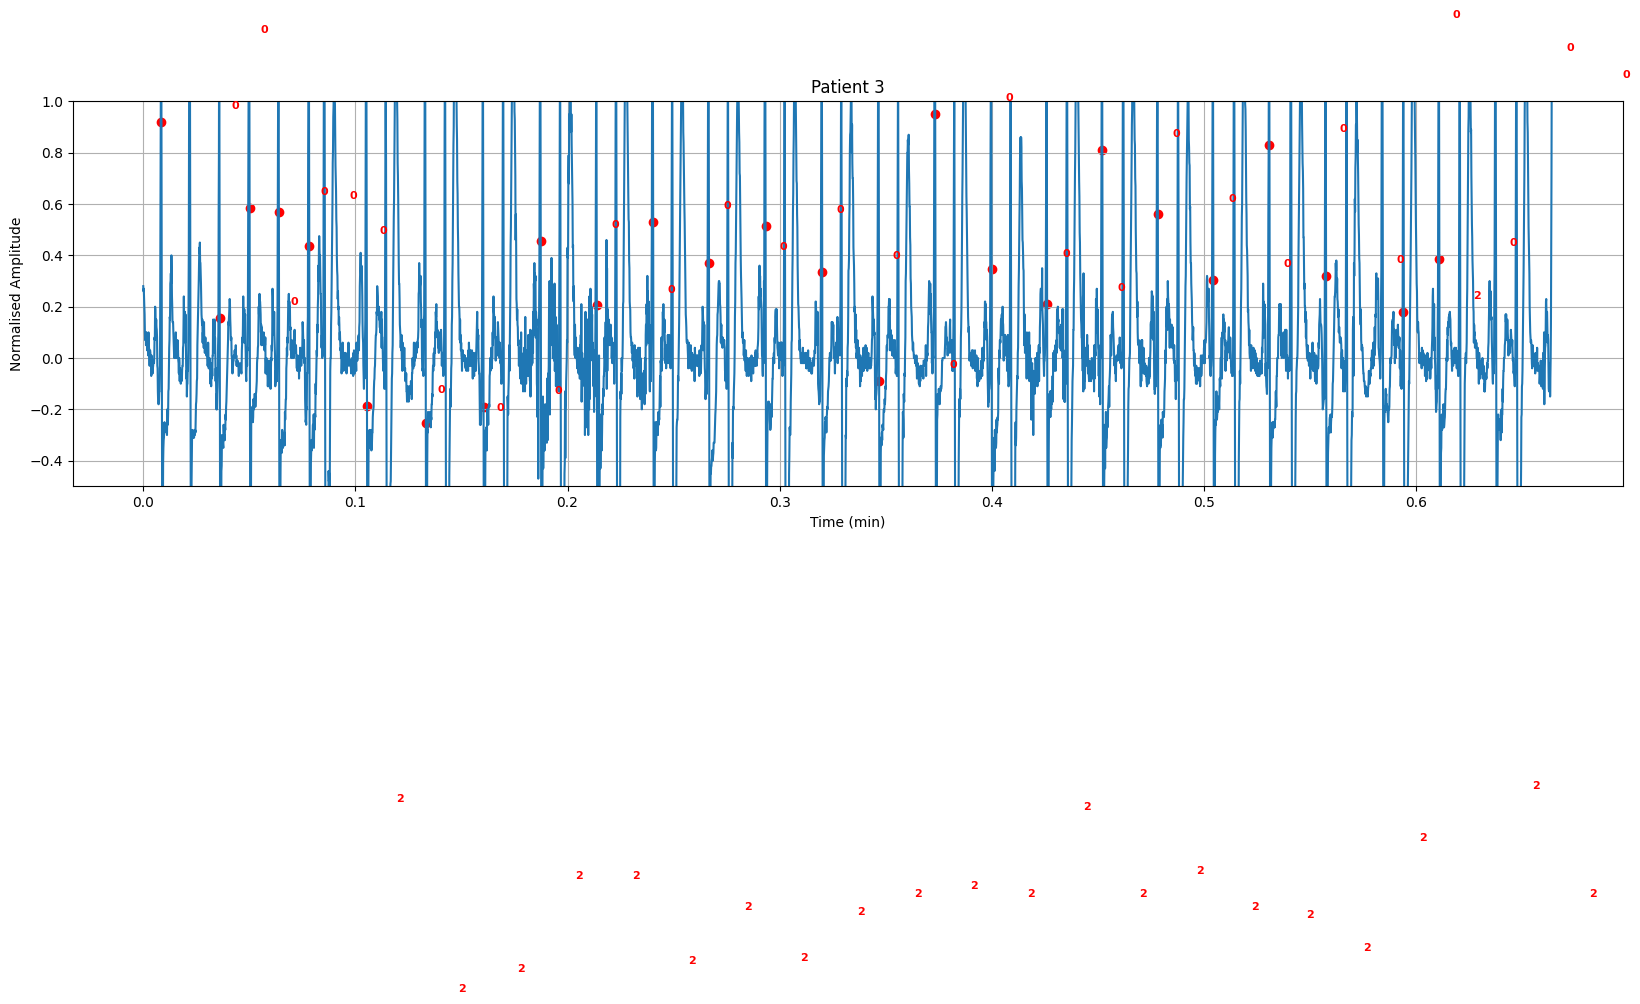

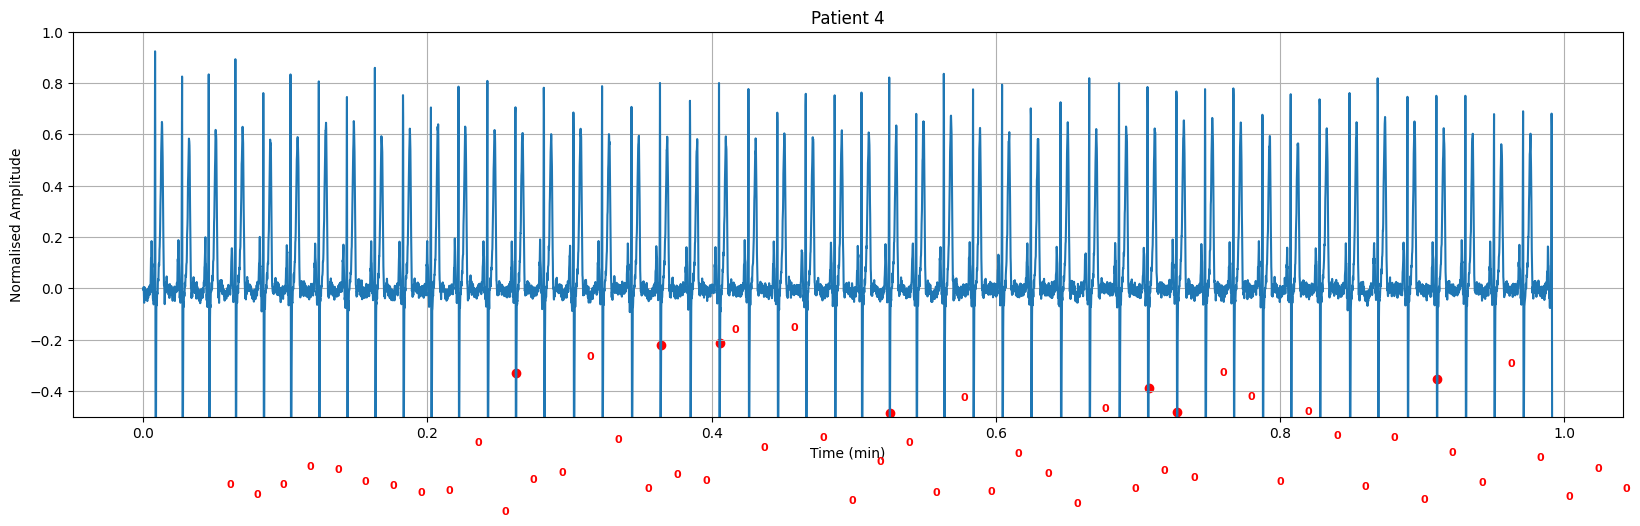

In [37]:
# Select first 5 patients
patients=dataset["train"].select(range(0,5))
for i in range(5):
  patient=patients[i]
  # Convert to np.array (list was giving me errors) and then slice the firt 50 beats
  beat_loc=np.asarray(patient["beat_locs"])[:50]
  beat_annot=np.asarray(patient["beat_labels"])[:50]
  # Slice signal to end where the location of the last (50th) beat is, using +1 to include it
  signal=np.asarray(patient["signal"])[:beat_loc[-1]+1]


  plot_signal(signal=signal,beat_locations=beat_loc,beat_annotations=beat_annot, title=f"Patient {i}")

<br>

2. **Construct the beat-level dataset**

In [59]:
beat_waveforms = []
beat_annots = []

# Loop over all the patients
for patient in dataset["train"]:
    # Convert all to numpy array to avoid errors
    signal = np.asarray(patient["signal"])
    beat_locs = np.asarray(patient["beat_locs"])
    beat_annot = np.asarray(patient["beat_labels"])

    #Split beats into waveforms
    beats = split_by_beat(signal, beat_locs)

    # Add to list as ints not as list
    beat_waveforms.extend(beats)
    beat_annots.extend(beat_annot)


In [92]:
from torch.utils.data import Dataset

class BeatsDataset(Dataset):
    """Beat dataset inheriting from pytorch dataset, simply holds beat_waveforms and beat labels"""
    def __init__(self, beat_waveforms, beat_labels):
        self.beat_waveforms = beat_waveforms
        self.beat_labels = beat_labels

    def __getitem__(self, idx):
        # Convert input and target to tensors
        x = torch.tensor(self.beat_waveforms[idx])
        y = torch.tensor(self.beat_labels[idx])

        return x, y

    def __len__(self):
        return len(self.beat_waveforms)

<br>

3. **Apply a simple pre-processing filter**  

In [75]:
index_to_keep=[] #list of indexes of data points in waveforms that meet our requiremetns
# Loop through waveforms and check which points match the requirements and then store the index
for i in range(len(beat_waveforms)):
  if len(beat_waveforms[i]) > 31 and len(beat_waveforms[i]) < 256:
    index_to_keep.append(i)
# Filter out all indexes not in the list to keep
beat_waveforms_processed = [beat_waveforms[i] for i in index_to_keep]
beat_labels_processed = [beat_annots[i] for i in index_to_keep]

<br>

4. **Plot summary statistics**

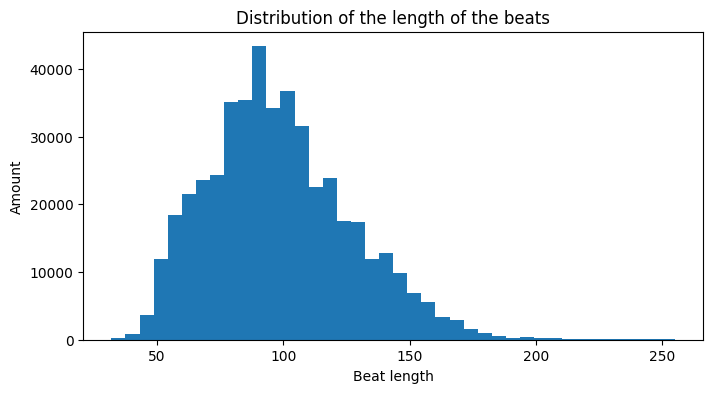

In [80]:
length_of_beats = [len(beat) for beat in beat_waveforms_processed] #get list of length of beats

plt.figure(figsize=(8, 4))
plt.hist(length_of_beats, bins=40)
plt.title("Distribution of the length of the beats")
plt.xlabel("Beat length")
plt.ylabel("Amount")
plt.show()

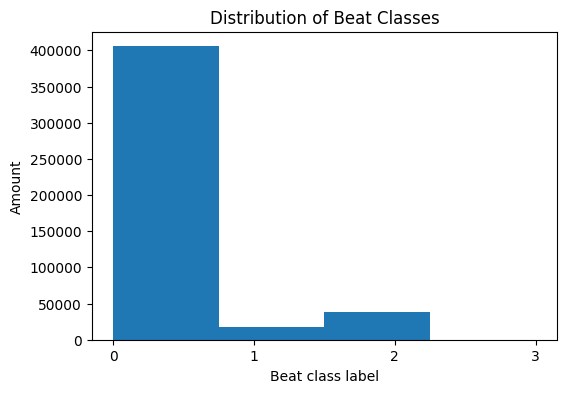

In [86]:
plt.figure(figsize=(6, 4))
plt.hist(beat_labels_processed, bins=4)
plt.xticks(range(4))
plt.title("Distribution of Beat Classes")
plt.xlabel("Beat class label")
plt.ylabel("Amount")

plt.show()

<br><br>

## 2.B) Classification and Anomaly Detection

In this part you will build a supervised **beat-level classifier** using the segmented beats prepared in Part 2.A. Each beat is treated as an individual sample with a label in the simplified index space (0–4). Key points to consider:

- You should drop all beats with a label of **3** and only train the classifier for labels **0**, **1** and **2**. This will make the training easier, given the significant class imbalance.

- Beats naturally vary in duration, so you must decide how to convert them into a consistent representation suitable for a model. You are free to choose any reasonable approach; at the simplest level, you may choose to zero-pad beats to a fixed length, but more refined strategies are also acceptable.

- You are expected to design the full solution **yourself**: the model, the preprocessing pipeline, the train/validation splits, and the overall training procedure. You must also decide on **suitable evaluation metrics** for this problem.

- As established in Part 2.A, the dataset is **heavily imbalanced**, with normal beats dominating the distribution. This affects both training and evaluation: models that ignore imbalance tend to overfit normal beats while failing on minority abnormal classes. **Strong solutions will address imbalance explicitly and will aim to produce models that perform reliably across all classes, not only the majority one.** You are, therefore, required to report each validation metric twice: one for normal (0) and one for abnormal (1-2), separately.

- Only include code that is necessary to reproduce your results. Notebook organisation and clarity form part of the assessment (see the main *README*).

- You should ensure that the notebook clearly displays how your chosen **evaluation metric(s) evolve over training iterations or epochs.**

- You may include **up to two** solutions in this notebook, in recognition that partially working attempts may still receive marks under the criteria outlined in the *README*, but you are encouraged to start with a simple, reliable baseline before attempting a more complex model.


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

In [88]:
#Drop all beats with a label of 3
beat_waveforms_final = []
beat_labels_final = []
for i in range(len(beat_waveforms_processed)):
  if beat_labels_processed[i] == 3:
    pass
  else:
    beat_waveforms_final.append(beat_waveforms_processed[i])
    beat_labels_final.append(beat_labels_processed[i])

In [99]:
beat_waveforms_final_padded = []

#Add zero padding to each beat wave at the end, ensuring they are all 256 long
for beat in beat_waveforms_final:
    padded = np.zeros(256, dtype=np.float32)
    n = min(len(beat), 256)
    padded[:n] = beat[:n]
    beat_waveforms_final_padded.append(padded)

In [100]:
from sklearn.model_selection import StratifiedShuffleSplit

beat_labels_final = np.asarray(beat_labels_final)
# Split dataset into train (80% of og dataset) and validation (20% of og dataset)
# Using stratified split ensures all classes are proportionally represented in both splits
strat_split = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

# Only 1 split so use next to just get the split indexes
train_idx, val_idx = next(strat_split.split(beat_waveforms_final_padded, beat_labels_final))

# Split our data into X and y , train and val, by adding data in its respective indexes
X_train = [beat_waveforms_final_padded[i] for i in train_idx]
y_train = [beat_labels_final[i]   for i in train_idx]

X_val = [beat_waveforms_final_padded[i] for i in val_idx]
y_val = [beat_labels_final[i]   for i in val_idx]




In [167]:
# Hyperparameters
lr = 1e-3
batch_size=64
num_workers = 0
wd = 1e-6
nepochs = 40

In [103]:
from torch.utils.data import DataLoader
train_dataset=BeatsDataset(X_train,y_train)
valid_dataset=BeatsDataset(X_val,y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [159]:
import torch.nn as nn
class MLP(nn.Module):
  def __init__(self, input_dim=256, num_classes=3):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)

        self.fc5 = nn.Linear(64, num_classes)

        self.relu= nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(p=0.2)


  def forward(self, x):
      x = self.fc1(x)
      x = self.bn1(x)
      x = self.relu(x)

      x = self.fc2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x= self.dropout(x)

      x = self.fc3(x)
      x = self.bn3(x)
      x = self.relu(x)
      x = self.dropout(x)

      x = self.fc4(x)
      x = self.bn4(x)
      x = self.relu(x)
      x = self.dropout(x)

      x = self.fc5(x)
      return x


In [104]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")


Cuda installed! Running on GPU!


In [137]:
# Same standard training and validation loop as usual, no need to iterate like Q1
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0.
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        train_loss += loss*input.size(0)
        optimizer.step()
    train_loss = train_loss / len(data_loader.dataset)
    return train_loss


def valid(model, criterion, data_loader):
    model.eval()
    valid_loss = 0.
    with torch.no_grad():
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)
            output = model(input)
            loss = criterion(output, target)
            valid_loss += loss*input.size(0)

        valid_loss = valid_loss / len(data_loader.dataset)

        return valid_loss

In [ ]:
!pip install pycm livelossplot
%pylab inline


In [118]:
# To handlel class imablance i will calculate weights representative of their proportion for the cross entropy loss
counts=np.bincount(y_train)
total=len(y_train)
loss_weights=[]
for cl in counts:
  loss_weights.append(total/cl)
loss_weights=torch.tensor(loss_weights, dtype=torch.float32).to(device)

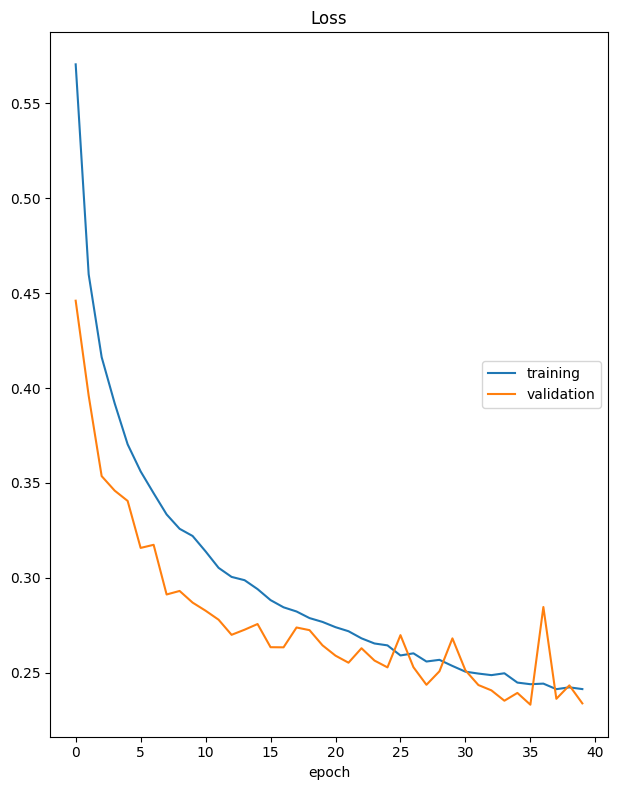

Loss
	training         	 (min:    0.241, max:    0.571, cur:    0.241)
	validation       	 (min:    0.233, max:    0.446, cur:    0.234)


In [168]:
from livelossplot import PlotLosses
from torch.utils.data import DataLoader
liveloss = PlotLosses()

# Define Model, Loss, optimiser
model = MLP().to(device)
loss_fn = nn.CrossEntropyLoss(weight=loss_weights)
optimiser = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=wd)

# Training/Val loop, performs training and then validation every epoch
for i in range(nepochs):
    # Mean Loss of training and then validation loop
    train_loss = train(model, optimiser, loss_fn, train_loader)
    print("train done")
    valid_loss = valid(model, loss_fn, valid_loader)
    print("valid done")

    # Liveloss plot, code below taken and adjusted from lectures/exercises
    logs = {}
    logs['' + 'loss'] = train_loss.item()
    logs['val_' + 'loss'] = valid_loss.item()
    liveloss.update(logs)
    liveloss.draw()



Test set: Average Accuracy: 84163/92158 (91%)


Validation set: f1: 0.7729894959484618)



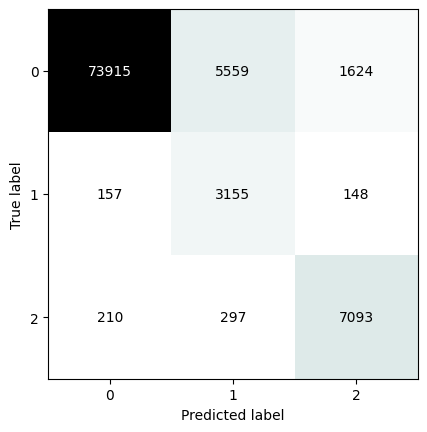

In [169]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
# Code taken from exercise/lecture adjusted by me to also calculate f1 score
def evaluate(model, data_loader):
    "Get model predictions on test dataset"
    model.eval()
    preds, targets = [],[]
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device) # move data to be on gpu with model
            logp = model(data)
            pred = logp.argmax(dim=1)# get the index of the max log-probability

            preds.append(pred)
            targets.append(target)

    preds = torch.concat(preds)
    targets = torch.concat(targets)
    #Calculate accuracy of model
    correct = preds.eq(targets).sum().item()
    print('\nTest set: Average Accuracy: {}/{} ({:.0f}%)\n'.format(
          correct, len(data_loader.dataset), 100.*correct/len(data_loader.dataset)))

    #Move to cpu so data can be used for matplot and sklearn
    preds= preds.cpu()
    targets= targets.cpu()

    # Calculate F1 score of model
    f1 = f1_score(targets,preds, average='macro')
    print(f"\nValidation set: f1: {f1})\n")

    plt.figure()
    ConfusionMatrixDisplay.from_predictions(targets, preds, ax=plt.gca(), colorbar=False, cmap='bone_r')
    plt.show()

evaluate(model, valid_loader)

<br><br>

## 2.C) Discussion (max 250 words)

Reflect critically on your solution to Part 2.B. In your discussion, address the following points:

1. **Modelling choices**

   Explain the main decisions behind your model design(s) and why you believe these choices are suitable for this task.

2. **Performance and validation**
   
   Interpret your model’s performance on normal versus abnormal beats using the evaluation metrics you selected. Comment on how class imbalance affected the results and what strategies you have sought to mitigate its impact.

3. **Limitations and improvements**
   
   Identify the main limitations of your approach and outline specific steps that could meaningfully improve performance. You may refer to architectural changes, alternative representations, different imbalance-handling strategies, or improved validation schemes.

Your answer should be technically focused, directly address these points, and remain within the stated word limit. Overly long or off-topic discussions will be penalised.


<br>

---

<br>

1. Used an MLP as it is built to handle classification problems such as this, with batchnorm to help stabilise training and leaky relu to prevent vanishing gradients, I used cross entropy loss as we have multiple classes that we are trying to predict and I passed weights to it, these weights stop the cross entropy from being really low from predicting the majority class correct most of the time, despite it poorly predicting other classes. I calculated the weights by getting
the inverse proportion of the frequency.

2. For normal beats we can see in the confusion matrix that the majority of the time it is correct, however, for class 1 we can see it hasnt learned it too well and outputs 0 more often than 1, for class 2, it does predict class 2 mostly but also 0 often. To try mitigate the affects of class imbalance i split my data using stratified sampling so that each dataset has a proportional representation, then I used weights as described earlier to ensure the model is heavily penalised for the abnormal classes so that it is pushed to predict them correctly too. Overall though it still did fairly well, receving an F1 score of 0.77 which is not low at all.

3. The main limitation is that my model is relatively straightforward and not complex, a 1D CNN may outperform it.



<br>

---

<br>